# Semi Synthetic Experiment 
Semi-synthetic dataset experiment

In [1]:
import sys 
sys.path.append('../..')
sys.path.append('/opt/anaconda3/lib/python3.7/site-packages')

import cox
from cox.store import Store
from cox.utils import Parameters
from cox.readers import CollectionReader
import torch as ch
from torch import Tensor
import torch.linalg as LA
from torch.utils.data import DataLoader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression
import math
from sklearn.metrics import r2_score
import os
import datetime
from sklearn.datasets import load_boston
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D 
import subprocess

from delphi import oracle 
from delphi.stats.linear_regression import TruncatedRegression

# set environment variable so that stores can create output files
# os.environ['HDF5_USE_FILE_LOCKING'] = 'FALSE'

TABLE_NAME = 'logs'
COMMAND = 'RScript'

# commands and arguments
COMMAND = 'Rscript'
PATH2SCRIPT = './truncreg.R'
TMP_FILE = 'tmp.csv'
RESULT_FILE = 'result.csv'

# mean squared error loss
mse_loss = ch.nn.MSELoss()

# Import Dataset into Notebook

In [3]:
dataset = '/Users/patroklos/Desktop/research/pm10.csv'
df = pd.read_csv(dataset)
df.head()

,pm10_concentration,cars_per_hour,temperature_at_2m,wind_speed,temperature_diff_2m_25m,wind_direction,hour_of_day,day
0,3.66356,7.74414,-4.4,4.2,0.0,18.0,19,116
1,3.04452,8.03398,-5.7,4.8,-0.3,69.1,9,506
2,3.71357,4.70048,-13.5,4.3,0.2,80.0,3,95
3,2.94444,7.52510,1.4,3.0,0.1,177.0,22,161
4,4.06044,7.76260,4.1,5.6,1.1,287.0,7,80


In [4]:
(df == '?').sum()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


pm10_concentration         0
cars_per_hour              0
temperature_at_2m          0
wind_speed                 0
temperature_diff_2m_25m    0
wind_direction             0
hour_of_day                0
day                        0
dtype: int64

The first thing that we want to do is check if there are any columns with NaN values in the dataframe.

In [11]:
nan_values = df.isna()
nan_columns = nan_values.any()

columns_with_nan = df.columns[nan_columns].tolist()
print(columns_with_nan)

[]


We see that there are two columsn with NaN values in them. We will fill the values of these columns with the mean of the rest of the data for the feature.

# Data Exploration

In [13]:
df = df.apply(pd.to_numeric)
df

,pm10_concentration,cars_per_hour,temperature_at_2m,wind_speed,temperature_diff_2m_25m,wind_direction,hour_of_day,day
0,3.66356,7.74414,-4.4,4.2,0.0,18.0,19,116
1,3.04452,8.03398,-5.7,4.8,-0.3,69.1,9,506
2,3.71357,4.70048,-13.5,4.3,0.2,80.0,3,95
3,2.94444,7.52510,1.4,3.0,0.1,177.0,22,161
4,4.06044,7.76260,4.1,5.6,1.1,287.0,7,80
...,...,...,...,...,...,...,...,...
495,2.30259,5.61677,-1.3,2.8,-0.1,65.2,1,486
496,4.11087,7.71110,-5.1,0.7,0.3,60.0,10,99
497,3.40120,6.25190,0.1,1.0,0.2,87.0,24,111
498,3.68888,7.85516,6.5,5.2,-0.2,69.0,19,196


In [14]:
X, y = Tensor(df[['cars_per_hour', 'wind_speed']].to_numpy()), Tensor(df['pm10_concentration'].to_numpy()[...,None])

(array([ 8.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  3.,  0.,  0.,  0.,  0.,
         0.,  4.,  0.,  0.,  0.,  0.,  6.,  0.,  0.,  0.,  6.,  0.,  0.,
        13.,  0.,  0., 14.,  0.,  9.,  0.,  0., 13.,  0.,  5.,  0., 14.,
        14.,  0., 11.,  8.,  0.,  6.,  7.,  4., 10., 15.,  0., 17., 23.,
        12., 12., 13., 13., 19., 16., 11.,  6., 12.,  4.,  9., 10., 13.,
         9.,  4.,  8.,  8.,  3., 11.,  7.,  7.,  4.,  8.,  6.,  3.,  5.,
         6.,  4.,  7.,  2.,  3.,  6.,  4.,  3.,  0.,  3.,  4.,  1.,  5.,
         0.,  1.,  1.,  1.,  1.,  2.,  1.,  0.,  2.]),
 array([0.69315   , 0.7401548 , 0.78715956, 0.8341644 , 0.8811692 ,
        0.92817396, 0.9751788 , 1.0221835 , 1.0691884 , 1.1161932 ,
        1.163198  , 1.2102028 , 1.2572076 , 1.3042123 , 1.3512172 ,
        1.398222  , 1.4452268 , 1.4922316 , 1.5392364 , 1.5862412 ,
        1.633246  , 1.6802508 , 1.7272556 , 1.7742604 , 1.8212652 ,
        1.86827   , 1.9152747 , 1.9622796 , 2.0092845 , 2.0562892 ,
        2.103294  , 2.1502

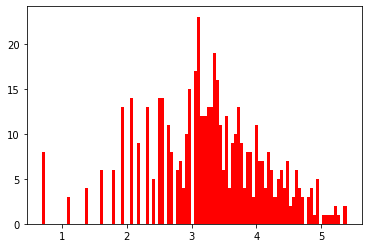

In [4]:
plt.hist(y.T, bins=100, color='red')

# Create Correlation Matrix
Create a correlation matrix to see which features are correlated to air quality data collection.

In [299]:
df = df[columns]

In [8]:
corr_matrix = df.corr()
corr_matrix

,ZN,CHAS,NOX,RM,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
ZN,1.000000,-0.042697,-0.516604,0.311991,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
CHAS,-0.042697,1.000000,0.091203,0.091251,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
NOX,-0.516604,0.091203,1.000000,-0.302188,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
RM,0.311991,0.091251,-0.302188,1.000000,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
DIS,0.664408,-0.099176,-0.769230,0.205246,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
RAD,-0.311948,-0.007368,0.611441,-0.209847,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
TAX,-0.314563,-0.035587,0.668023,-0.292048,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536
PTRATIO,-0.391679,-0.121515,0.188933,-0.355501,-0.232471,0.464741,0.460853,1.000000,-0.177383,0.374044,-0.507787
B,0.175520,0.048788,-0.380051,0.128069,0.291512,-0.444413,-0.441808,-0.177383,1.000000,-0.366087,0.333461
LSTAT,-0.412995,-0.053929,0.590879,-0.613808,-0.496996,0.488676,0.543993,0.374044,-0.366087,1.000000,-0.737663


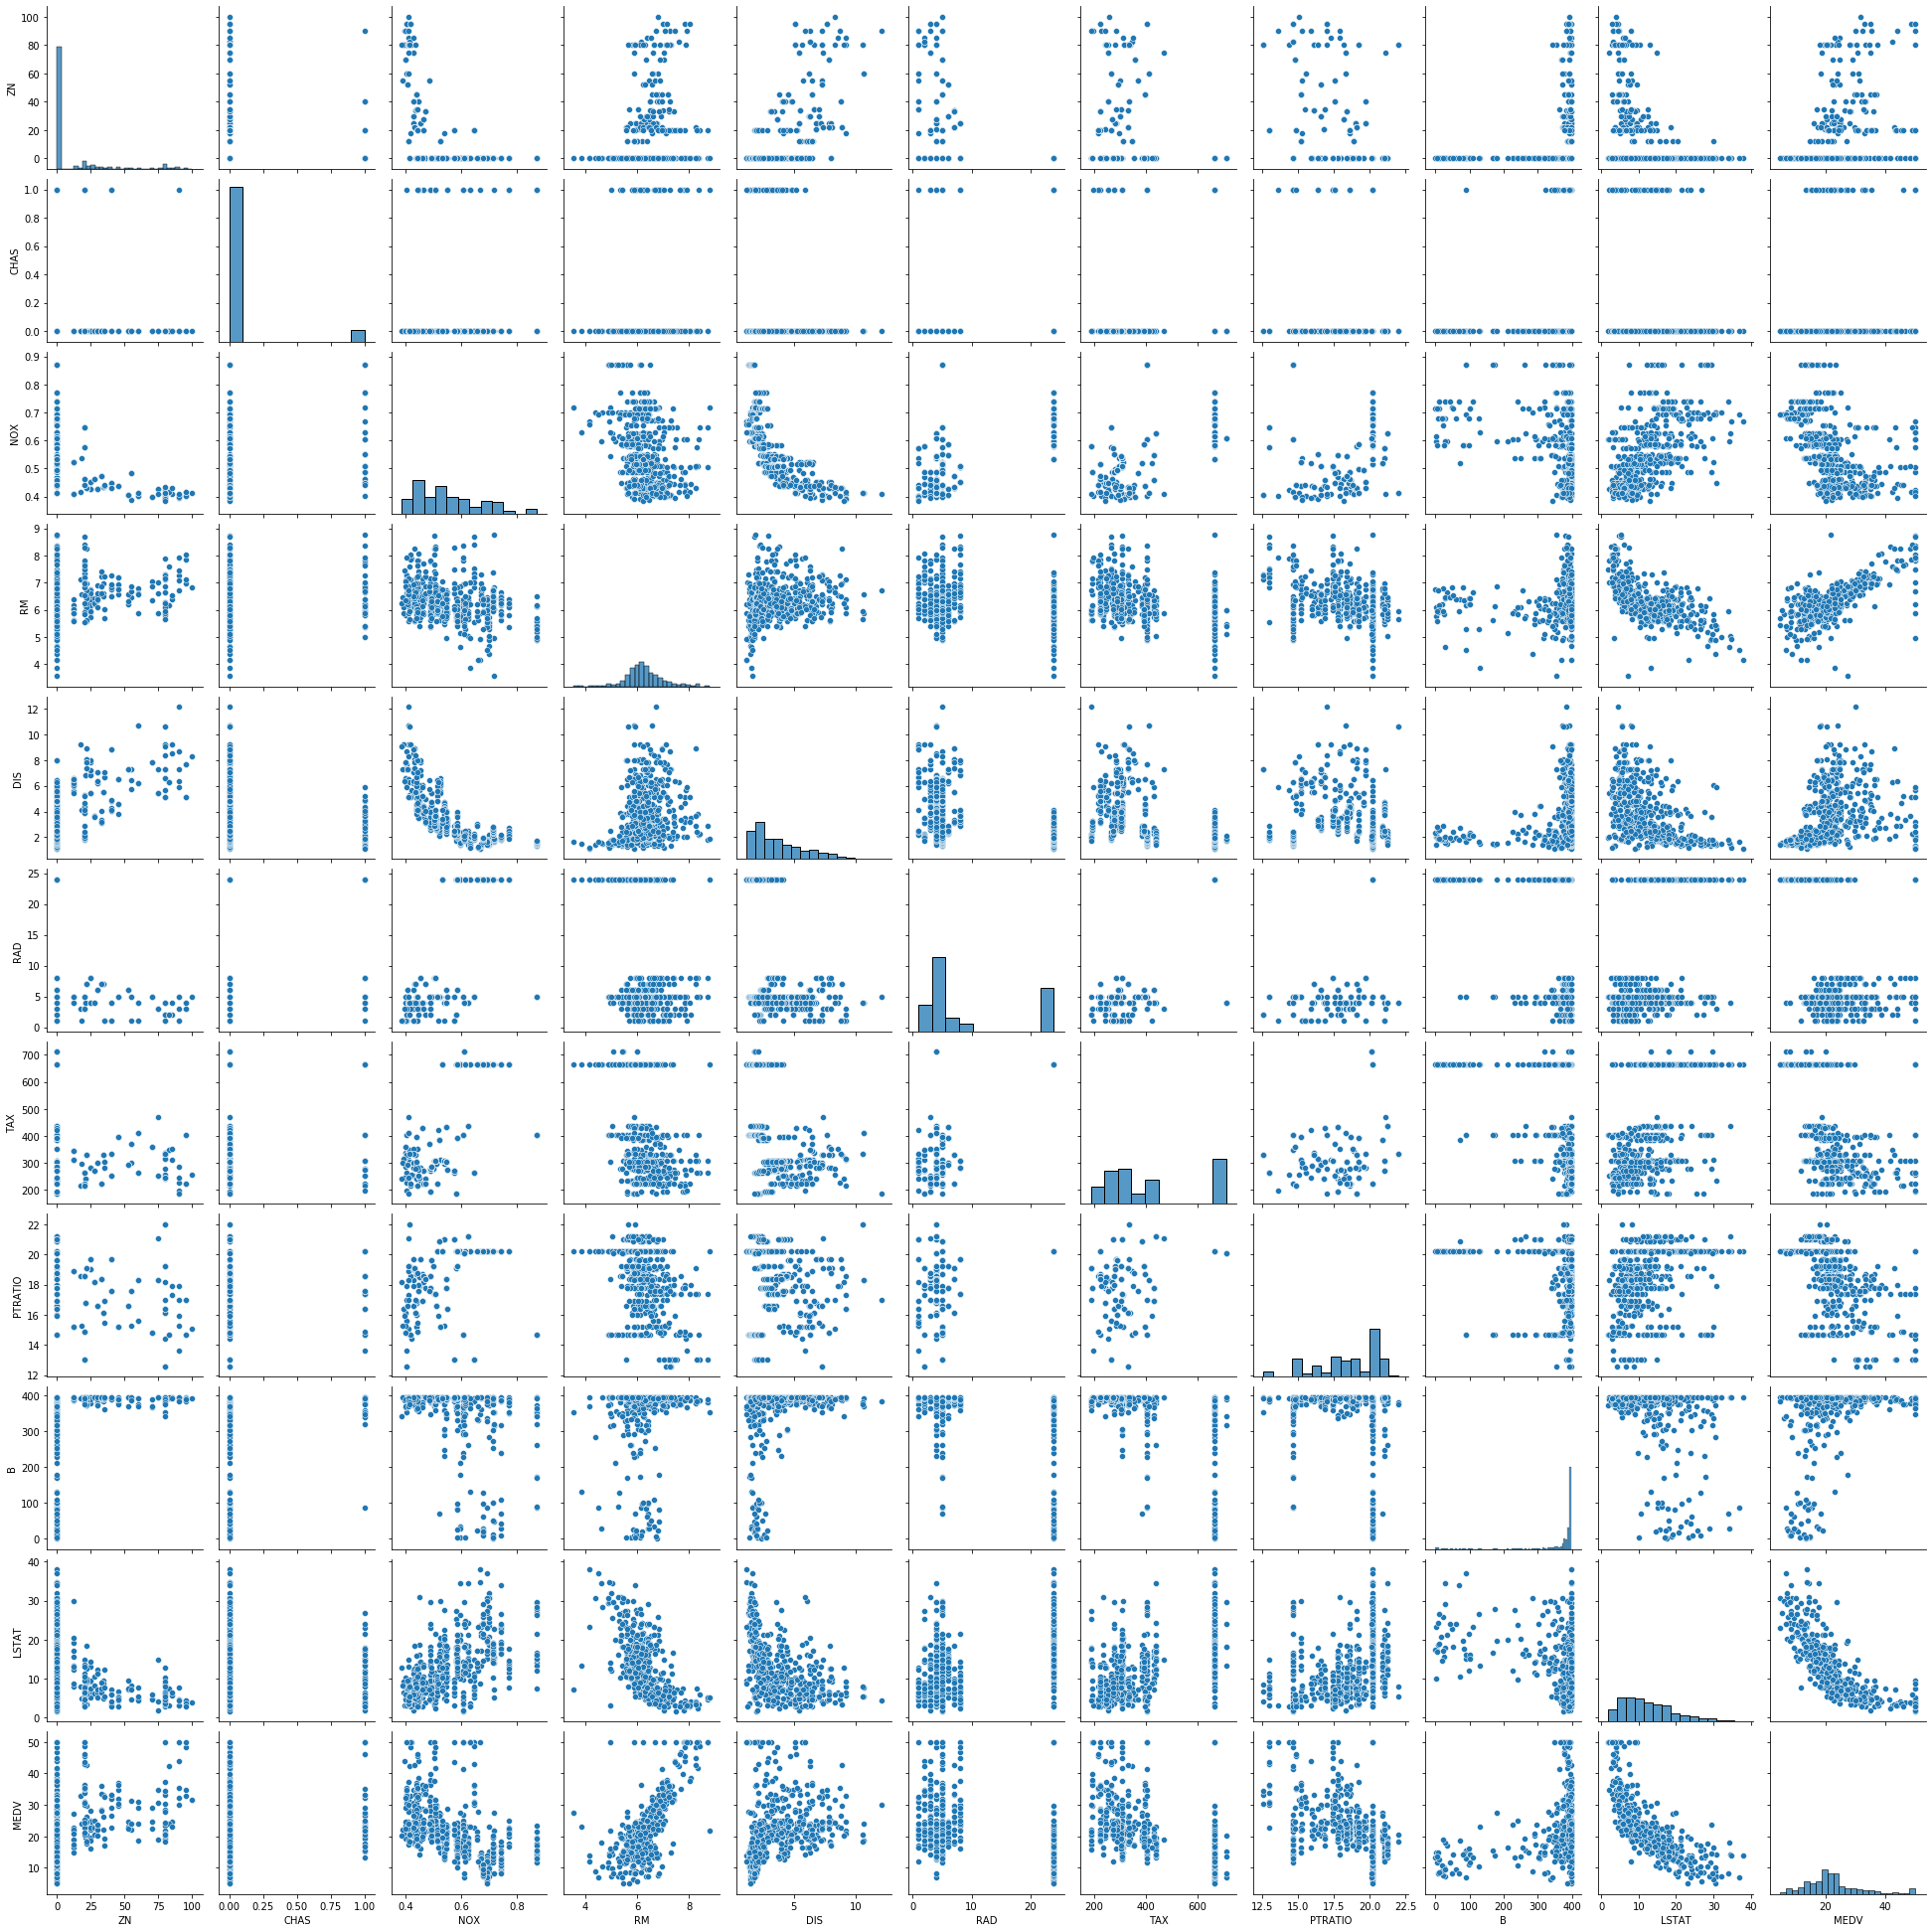

In [11]:
sns.pairplot(df)

First, let's take see if there is a linear relationship between solar.R and Ozone.

In [5]:
data = ch.linspace(0, 1500, 100).reshape(100, 1)

gt_ols = LinearRegression()
gt_ols.fit(X, y)
score = gt_ols.score(X, y)
print("r^2: ", score)
gt_var = (y - gt_ols.predict(X)).var(0)
print('ground-truth variance: ', float(gt_var))

r^2:  0.1728636862809666
ground-truth variance:  0.6504841446876526


# Now we standardize our empirical data and generate new ols estimates

In [6]:
# random = ch.randn(X.shape[1], 2)
random = ch.eye(X.shape[1], 2)
x_transform = X@random
w_transform = Tensor(gt_ols.coef_)@random

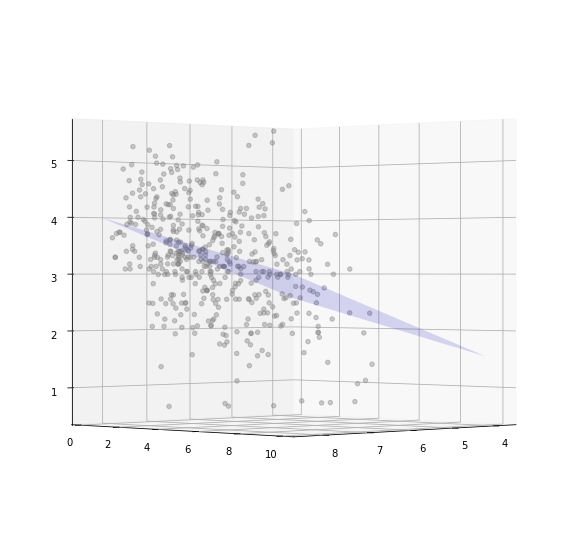

In [21]:
fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')

x_max, x_min = x_transform.max(0)[0], x_transform.min(0)[0]
X_ = np.arange(x_min[0], x_max[0], .1)
Y = np.arange(x_min[1], x_max[1], .1)
X_, Y = np.meshgrid(X_, Y) 


actual = Tensor([])
for i in range(X_.shape[0]): 
    input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
    actual = ch.cat([actual, input_@w_transform.T + gt_ols.intercept_], 1)
ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue')

ax.scatter3D(x_transform[:,0], x_transform[:,1], y, color='grey', label='S', alpha=.4)
ax.view_init(0, 45)

# Truncate Dataset

In [32]:
phi = oracle.Left(3.25)
indices = phi(y).flatten().nonzero(as_tuple=False).flatten()
x_trunc, y_trunc = X[indices], y[indices]
alpha = x_trunc.size(0) / X.size(0)
print("alpha: ", alpha)

alpha:  0.532


In [33]:
trunc_ols = LinearRegression()
trunc_ols.fit(x_trunc, y_trunc) 
score = trunc_ols.score(X, y)
print("r^2: ", score)
emp_var = (y_trunc - trunc_ols.predict(x_trunc)).var(0)
print('empirical variance: ', float(emp_var))

r^2:  -0.3894665234800925
empirical variance:  0.26433953642845154


In [34]:
x_trunc_transform = x_transform[indices]
w = Tensor(trunc_ols.coef_)@random

# Data Preprocessing
We will now use our algorithms to try to correct for this bias.

In [35]:
data = ch.linspace(0, 1.5, 100).reshape(-1, 1)

# scale wind by actual noise variance
y_trunc_mu = y_trunc.mean(0)
y_trunc_scaled = (y_trunc - y_trunc_mu) / ch.sqrt(gt_var)
y_scaled = (y - y_trunc_mu) / ch.sqrt(gt_var)

beta = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()*math.sqrt(X.size(1))
x_trunc_norm = x_trunc / beta
x_norm = X / beta

scaled_ols = LinearRegression()
scaled_ols.fit(x_norm, y_scaled)

trunc_scaled_ols = LinearRegression()
trunc_scaled_ols.fit(x_trunc_norm, y_trunc_scaled)

LinearRegression()

In [36]:
data = ch.linspace(0, 1.5, 100).reshape(-1, 1)

# scale wind by actual noise variance
y_trunc_mu = y_trunc.mean(0)
y_trunc_emp_scaled = (y_trunc - y_trunc_mu) / ch.sqrt(emp_var)
y_emp_scaled = (y - y_trunc_mu) / ch.sqrt(emp_var)

beta = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()*math.sqrt(X.size(1))
x_trunc_norm = x_trunc / beta
x_norm = X / beta

emp_scaled_ols = LinearRegression()
emp_scaled_ols.fit(x_norm, y_emp_scaled)

trunc_emp_scaled_ols = LinearRegression()
trunc_emp_scaled_ols.fit(x_trunc_norm, y_trunc_emp_scaled)

LinearRegression()

In [37]:
x_trunc_norm.size(), y_trunc_emp_scaled.size()

(torch.Size([266, 2]), torch.Size([266, 1]))

In [38]:
w_trunc_transform = Tensor(trunc_ols.coef_)@random

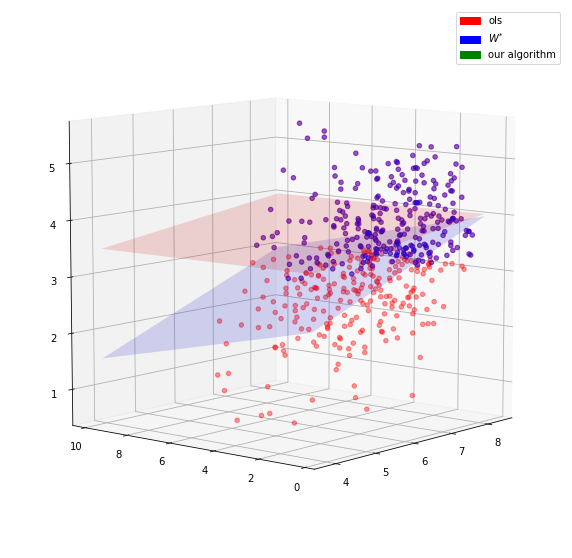

In [39]:
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')


x_max, x_min = x_transform.max(0)[0], x_transform.min(0)[0]
X_ = np.arange(x_min[0], x_max[0], .1)
Y = np.arange(x_min[1], x_max[1], .1)
X_, Y = np.meshgrid(X_, Y) 

with ch.no_grad():
    emp = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        emp = ch.cat([emp, input_@w.T + trunc_ols.intercept_], 1)
    ax.plot_surface(X_, Y, emp.numpy().T, alpha=.15, color='red')
    
    actual = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        actual = ch.cat([actual, input_@w_transform.T + gt_ols.intercept_], 1)
    ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue')
    
ax.scatter3D(x_transform[:,0], x_transform[:,1], y, color='red', label='entire dataset', alpha=.4)
ax.scatter3D(x_trunc_transform[:,0], x_trunc_transform[:,1], y_trunc, color='blue', label='S', alpha=.4)

red_patch = mpatches.Patch(color='red', label='ols')
green_patch = mpatches.Patch(color='green', label='our algorithm')
blue_patch = mpatches.Patch(color='blue', label="$W^{*}$")
plt.legend(handles=[red_patch, blue_patch, green_patch], loc="upper right")
    
ax.view_init(9.0, 220)

Now, we will our truncated regression algorithm with known variance of the truncated regression data.

In [40]:
scaled_phi = oracle.Left((phi.left - y_trunc_mu) / ch.sqrt(gt_var))
known_trunc_reg = TruncatedRegression(phi=scaled_phi, alpha=Tensor([alpha]), lr=1e-1, unknown=False, bs=100, n=100, tol=1e-2, steps=2500, val=int(.2*y_trunc.size(0)))
known_trunc_reg.fit(x_trunc_norm, y_trunc_scaled)

weight bounds:  Bounds(lower=tensor([-22.8259, -24.6979]), upper=tensor([26.3622, 24.4902]))
bias bounds:  Bounds(lower=-25.54062271118164, upper=23.647518157958984)
var bounds:  None
Iteration 1 | Score: 0.07309597730636597
Iteration 2 | Score: 0.06796908378601074
Iteration 3 | Score: 0.06021641567349434
Iteration 4 | Score: 0.05793970823287964
Iteration 5 | Score: 0.08361029624938965
Iteration 6 | Score: 0.08450746536254883
Iteration 7 | Score: 0.057083338499069214
Iteration 8 | Score: 0.06637333333492279
Iteration 9 | Score: 0.05174117162823677
Iteration 10 | Score: 0.06373028457164764
Iteration 11 | Score: 0.06135757267475128
Iteration 12 | Score: 0.07265198230743408
Iteration 13 | Score: 0.05918958783149719
Iteration 14 | Score: 0.07740086317062378
Iteration 15 | Score: 0.07004275172948837
Iteration 16 | Score: 0.05579310283064842
Iteration 17 | Score: 0.0734415054321289
Iteration 18 | Score: 0.07696844637393951
Iteration 19 | Score: 0.06256385147571564
Iteration 20 | Score: 0.085

Linear(in_features=2, out_features=1, bias=True)

In [41]:
known_w, known_w0 = (known_trunc_reg.weight * ch.sqrt(gt_var)) / beta, known_trunc_reg.intercept * ch.sqrt(gt_var) + y_trunc_mu

In [43]:
mse_loss(ch.cat([known_w.flatten(), known_w0]), ch.cat([Tensor(gt_ols.coef_.flatten()), Tensor(gt_ols.intercept_)]))**.5

tensor(0.5446)

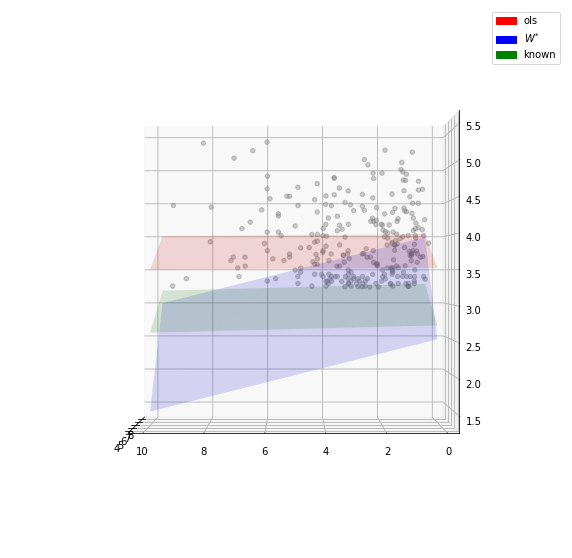

In [132]:
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')


# ax.scatter3D(x_non_trunc[:,0], x_non_trunc[:,1], y_non_trunc, color='red', label='not seen', alpha=.1)


x_max, x_min = x_transform.max(0)[0], x_transform.min(0)[0]
X_ = np.arange(x_min[0], x_max[0], 0.1)
Y = np.arange(x_min[1], x_max[1], 0.1)
X_, Y = np.meshgrid(X_, Y) 

with ch.no_grad():
    emp = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        emp = ch.cat([emp, input_@w.T + trunc_ols.intercept_], 1)
    ax.plot_surface(X_, Y, emp.numpy().T, alpha=.15, color='red')
    
    actual = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        actual = ch.cat([actual, input_@w_transform.T + gt_ols.intercept_], 1)
    ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue')
    
    known_w_transform = known_w.T@random
    
    pred = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        pred = ch.cat([pred, input_@known_w_transform.T + known_w0], 1)
    ax.plot_surface(X_, Y, pred.numpy().T, alpha=.15, color='green')

ax.scatter3D(x_trunc_transform[:,0][...,None], x_trunc_transform[:,1][...,None], y_trunc, color='grey', label='S', alpha=.4)

    
red_patch = mpatches.Patch(color='red', label='ols')

green_patch = mpatches.Patch(color='green', label='known')
blue_patch = mpatches.Patch(color='blue', label="$W^{*}$")
plt.legend(handles=[red_patch, blue_patch, green_patch], loc="upper right")
    
ax.view_init(0.0, 180)

In [198]:
emp_scaled_phi = oracle.Left((phi.left - y_trunc_mu) / ch.sqrt(emp_var))
unknown_trunc_reg = TruncatedRegression(phi=emp_scaled_phi, alpha=Tensor([alpha]), unknown=True, lr=1e-1, step_lr_gamma=.9, bs=10, n=10, tol=1e-1, steps=2500, val=int(.2*y_trunc.size(0)))
unknown_trunc_reg.fit(x_trunc_norm, y_trunc_emp_scaled)

weight bounds:  Bounds(lower=tensor([-31.8368, -35.0175]), upper=tensor([37.3514, 34.1706]))
bias bounds:  Bounds(lower=-35.998985290527344, upper=33.18915557861328)
var bounds:  Bounds(lower=0.47994399070739746, upper=3.391542434692383)
Iteration 1 | Score: 0.2988682687282562
Iteration 2 | Score: 0.2594025135040283
Iteration 3 | Score: 0.24511504173278809
Iteration 4 | Score: 0.2314048409461975
Iteration 5 | Score: 0.1979217529296875
Iteration 6 | Score: 0.26657047867774963
Iteration 7 | Score: 0.21176403760910034
Iteration 8 | Score: 0.1718588024377823
Iteration 9 | Score: 0.2115965634584427
Iteration 10 | Score: 0.16542059183120728
Iteration 11 | Score: 0.19164545834064484
Iteration 12 | Score: 0.1763947606086731
Iteration 13 | Score: 0.15028151869773865
Iteration 14 | Score: 0.15129482746124268
Iteration 15 | Score: 0.1601129174232483
Iteration 16 | Score: 0.15494245290756226
Iteration 17 | Score: 0.17876167595386505
Iteration 18 | Score: 0.19623087346553802
Iteration 19 | Score: 0

Iteration 202 | Score: 0.14602169394493103
Iteration 203 | Score: 0.14283913373947144
Iteration 204 | Score: 0.1522156298160553
Iteration 205 | Score: 0.14849179983139038
Iteration 206 | Score: 0.1818665713071823
Iteration 207 | Score: 0.16699717938899994
Iteration 208 | Score: 0.17027735710144043
Iteration 209 | Score: 0.16792649030685425
Iteration 210 | Score: 0.16813603043556213
Iteration 211 | Score: 0.1553373783826828
Iteration 212 | Score: 0.16919316351413727
Iteration 213 | Score: 0.17121268808841705
Iteration 214 | Score: 0.1809769719839096
Iteration 215 | Score: 0.15109917521476746
Iteration 216 | Score: 0.16336922347545624
Iteration 217 | Score: 0.1603451818227768
Iteration 218 | Score: 0.1788148432970047
Iteration 219 | Score: 0.1891755908727646
Iteration 220 | Score: 0.17381562292575836
Iteration 221 | Score: 0.16109849512577057
Iteration 222 | Score: 0.1784885674715042
Iteration 223 | Score: 0.17201384902000427
Iteration 224 | Score: 0.16763250529766083
Iteration 225 | Sco

LinearUnknownVariance()

In [199]:
w_, w0_ = (unknown_trunc_reg.weight * ch.sqrt(emp_var)) / beta, unknown_trunc_reg.intercept * ch.sqrt(emp_var) + y_trunc_mu

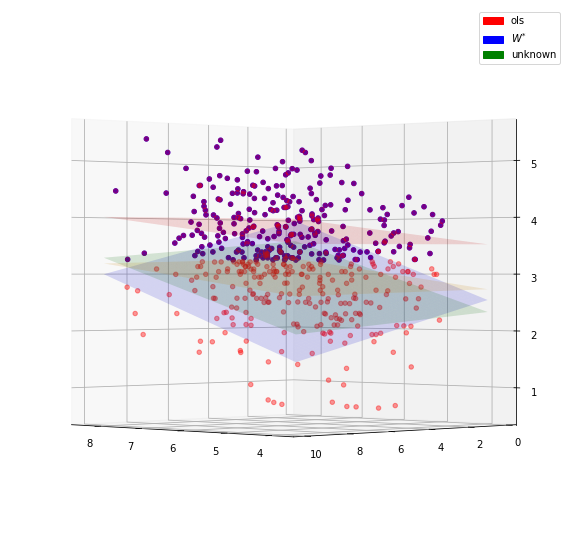

In [200]:
import matplotlib.patches as mpatches

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')


x_max, x_min = x_transform.max(0)[0], x_transform.min(0)[0]
X_ = np.arange(x_min[0], x_max[0], .1)
Y = np.arange(x_min[1], x_max[1], .1)
X_, Y = np.meshgrid(X_, Y) 

with ch.no_grad():
    emp = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        emp = ch.cat([emp, input_@w.T + trunc_ols.intercept_], 1)
    ax.plot_surface(X_, Y, emp.numpy().T, alpha=.15, color='red')
    
    actual = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        actual = ch.cat([actual, input_@w_transform.T + gt_ols.intercept_], 1)
    ax.plot_surface(X_, Y, actual.numpy().T, alpha=.15, color='blue')
    
    unknown_w_transform = w_.T@random
    
    pred = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        pred = ch.cat([pred, input_@unknown_w_transform.T + w0_], 1)
    ax.plot_surface(X_, Y, pred.numpy().T, alpha=.15, color='green')
    
    known_pred = Tensor([])
    for i in range(X_.shape[0]): 
        input_ = Tensor(np.hstack([X_[i].reshape(-1, 1), Y[i].reshape(-1, 1)]))
        known_pred = ch.cat([known_pred, input_@known_w_transform.T + known_w0], 1)
    ax.plot_surface(X_, Y, known_pred.numpy().T, alpha=.15, color='orange')

ax.scatter3D(x_transform[:,0], x_transform[:,1], y, color='red', label='entire dataset', alpha=.4)
ax.scatter3D(x_trunc_transform[:,0], x_trunc_transform[:,1], y_trunc, color='blue', label='S', alpha=1.0)
    
red_patch = mpatches.Patch(color='red', label='ols')
orange_patch = mpatches.Patch(color='red', label='known')
green_patch = mpatches.Patch(color='green', label='unknown')
blue_patch = mpatches.Patch(color='blue', label="$W^{*}$")
plt.legend(handles=[red_patch, blue_patch, green_patch], loc="upper right")
    
ax.view_init(0, 135)

In [136]:
unknown_params = ch.cat([w_, w0_]).flatten()
gt_params = Tensor(np.concatenate([gt_ols.coef_.flatten(), gt_ols.intercept_]))
trunc_ols_params = Tensor(np.concatenate([trunc_ols.coef_.flatten(), trunc_ols.intercept_]))
known_params = ch.cat([known_w.flatten(), known_w0.flatten()])

In [73]:
# spawn subprocess to run truncreg experiment
concat = ch.cat([x_trunc, y_trunc], dim=1).numpy()
"""
DATA FORMAT:
    -First n-1 columns are independent variables
    -nth column is dependent variable
"""
concat_df = pd.DataFrame(concat)
concat_df.to_csv(args.out_dir + '/' + TMP_FILE) # save data to csv
"""
Arguments
- c - truncation point (float)
- dir - left or right -> type of truncation (str)
"""
cmd = [COMMAND, PATH2SCRIPT] + [str(phi.left), str(x_trunc.size(1)), 'left', args.out_dir]

# check_output will run the command and store the result
st = datetime.datetime.now()
result = subprocess.check_output(cmd, universal_newlines=True)
trunc_res = Tensor(pd.read_csv(args.out_dir + '/' + RESULT_FILE)['x'].to_numpy())
trunc_reg_params = ch.cat([trunc_res[1:-1].flatten(), trunc_res[0][None,...]])

trunc_reg_pred = X@trunc_reg_params[:-1] + trunc_reg_params[-1]

# Set up Experiment
For storing the experiment's hyperparameters, we use [cox](https://github.com/MadryLab/cox), MadryLab's light-weight experimental design and analysis framework. 

In [16]:
args = Parameters({
    "bs": 10,
    "trials": 10,
    "steps": 1500,
    "out_dir": '/Users/patroklos/regression', 
    "table_name": 'results', 
    'tol': 1e-1,
    'n': 100,
    'lr': 1e-1,
    'step_lr': 100, 
    'step_lr_gamma': .9,
    'attempts': 3, 
    'val': .2,
})
EXP = 'AnotherTest'
mse_loss = ch.nn.MSELoss()

# Create Store for Experiment Results

In [17]:
def run_trial(kwargs, X, y, tol, attempts):
    """
    Runs a trial of a truncated regression experiment. Runs a maximum 
    of three trials of an experiment. The experiment terminates when either 
    the norm of teh score is less than 3e-1, or when three trials is up. After 
    three trials it returns the best truncated regression experiment.
    :param kwargs: keyword arguments for experiment 
    :param X: independent variable
    :param y: dependent variable
    :return: truncated regression experiment and time that experiment took
    """
    st = datetime.datetime.now()        
    # run procedure until get reasonable score
    attempt, score, best_trunc_reg = 0, None, None
    while (score is None or score.norm() > tol) and attempt < attempts:
        trunc_reg = TruncatedRegression(**kwargs)
        trunc_reg.fit(X, y)
        grad = trunc_reg.score()
        if score is None or grad.norm() < score.norm(): 
            score, best_trunc_reg = grad, trunc_reg
        attempt += 1
    total_time = int((datetime.datetime.now() - st).total_seconds())
    return best_trunc_reg, total_time   

# Run Procedure

In [18]:
# ground_truth parameters
gt = LinearRegression() 
gt.fit(X, y)
gt_params = Tensor(np.concatenate([gt.coef_.flatten() ,gt.intercept_]))
gt_var = Tensor(np.var(gt.predict(X) - y.numpy(), 0))

C = [1, 1.5, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 4.0]
for i in range(args.trials):
    # create store
    store = Store(args.out_dir + '/' + EXP)
    store.add_table(TABLE_NAME, { 
        'known_r2': float,
        'known_param_mse': float,
        'known_time': int,
        'unknown_param_mse': float,
        'unknown_var_l1': float,
        'unknown_r2': float,
        'unknown_time': int,
        'ols_r2': float, 
        'ols_param_mse': float,
        'ols_var_l1': float,
        'trunc_reg_param_mse': float, 
        'trunc_reg_var_l1': float,
        'trunc_reg_r2': float,
        'trunc_reg_time': int,
        'alpha': float, 
        'c': float, 
        'num_samples': int,
    })
    
    for c in C: 
        # truncate
        phi = oracle.Left(c)
        indices = phi(y).flatten().nonzero(as_tuple=False).flatten()
        x_trunc, y_trunc = X[indices], y[indices]
        # add survival probability to hyperparameters
        alpha = Tensor([x_trunc.size(0) / X.size(0)])
        
        y_trunc_mu = y_trunc.mean(0)
        
        # empirical linear regression
        ols = LinearRegression() 
        ols.fit(x_trunc, y_trunc)
        emp_noise_var = ch.var(Tensor(ols.predict(x_trunc)) - y_trunc, dim=0)[...,None]
        ols_params = ch.cat([Tensor(ols.coef_).T, Tensor(ols.intercept_)[..., None]]).flatten()
        print("c: ", c)
        print("emp noise var: ", emp_noise_var)
        print("gt var: ", gt_var)

        # ols results
        store[TABLE_NAME].update_row({
            'ols_r2': r2_score(y.flatten(), ols.predict(X).flatten()), 
            'ols_var_l1': ch.abs(emp_noise_var - gt_var),
            'ols_param_mse': mse_loss(ols_params, gt_params),
        })
        val = int(args.val*x_trunc.size(0))
        
        # normalize input data, so that assumption for algorithm is satisfied
        beta = LA.norm(x_trunc, dim=-1, ord=float('inf')).max()*math.sqrt(X.size(1))
        x_trunc_norm = x_trunc / beta
        
        
        phi_emp_scaled = oracle.Left((phi.left - y_trunc_mu) / ch.sqrt(emp_noise_var))
        y_trunc_emp_scaled = (y_trunc - y_trunc_mu) / ch.sqrt(emp_noise_var)
            
        # standardize noised by actual noise variance
        unknown_kwargs = { 
            'phi': phi_emp_scaled, 
            'alpha': alpha, 
            'bias': args.bias, 
            'unknown': True, 
            'bs': args.bs, 
            'n': args.n, 
            'tol': args.tol, 
            'steps': args.steps, 
            'step_lr': args.step_lr, 
            'step_lr_gamma': args.step_lr_gamma,
            'val': val
        }
        
        # truncated linear regression with unknown noise variance using empirical noise variance
        trunc_reg, total_time = run_trial(unknown_kwargs, x_trunc_norm, y_trunc_emp_scaled, args.tol, args.attempts)  
        
        w, w0 = (trunc_reg.weight * ch.sqrt(emp_noise_var)) / beta, trunc_reg.intercept * ch.sqrt(emp_noise_var) + y_trunc_mu
        unknown_params = ch.cat([w.flatten(), w0.flatten()])
        # known results
        store[TABLE_NAME].update_row({
            'unknown_r2': r2_score(y.flatten(), X@w + w0), 
            'unknown_param_mse': mse_loss(unknown_params, gt_params),
            'unknown_time': total_time, 
            'unknown_var_l1': ch.abs(trunc_reg.variance * emp_noise_var - gt_var)
        })
            
        # spawn subprocess to run truncreg experiment
        concat = ch.cat([x_trunc, y_trunc], dim=1).numpy()
        """
        DATA FORMAT:
            -First n-1 columns are independent variables
            -nth column is dependent variable
        """
        concat_df = pd.DataFrame(concat)
        concat_df.to_csv(args.out_dir + '/' + TMP_FILE) # save data to csv
        """
        Arguments
        - c - truncation point (float)
        - dir - left or right -> type of truncation (str)
        """
        cmd = [COMMAND, PATH2SCRIPT] + [str(c), str(x_trunc.size(1)), 'left', args.out_dir]

        # check_output will run the command and store the result
        st = datetime.datetime.now()
        result = subprocess.check_output(cmd, universal_newlines=True)
        trunc_res = Tensor(pd.read_csv(args.out_dir + '/' + RESULT_FILE)['x'].to_numpy())
        trunc_reg_params = ch.cat([trunc_res[1:-1].flatten(), trunc_res[0][None,...]])

        trunc_reg_pred = X@trunc_reg_params[:-1] + trunc_reg_params[-1]
        
        # truncreg results
        store[TABLE_NAME].update_row({
            'trunc_reg_r2': r2_score(y.flatten(), trunc_reg_pred.flatten()), 
            'trunc_reg_param_mse': mse_loss(trunc_reg_params, gt_params),
            'trunc_reg_var_l1': ch.abs(trunc_res[-1].pow(2)[None,...] - gt_var),
            'trunc_reg_time': int((datetime.datetime.now() - st).total_seconds()), 
            })   

        store[TABLE_NAME].append_row({ 
            'alpha': float(alpha), 
            'c': c,    
            'num_samples': x_trunc.size(0),
        })
            
    # close current store
    store.close()

Logging in: /Users/patroklos/regression/AnotherTest/46498389-6cab-4e8d-9d24-102aba40bd86
c:  1
emp noise var:  tensor([[0.5804]])
gt var:  tensor([0.6492])
weight bounds:  Bounds(lower=tensor([-14.6880, -21.3087]), upper=tensor([24.6604, 18.0397]))
bias bounds:  Bounds(lower=-21.797517776489258, upper=17.5509090423584)
var bounds:  None
Final Score: 0.06697285175323486
weight bounds:  Bounds(lower=tensor([-24.2753, -31.2585]), upper=tensor([35.0731, 28.0900]))
bias bounds:  Bounds(lower=-31.97085189819336, upper=27.377574920654297)
var bounds:  Bounds(lower=0.4967268407344818, upper=1.0260237455368042)
Iteration 1 | Score: 0.2543903589248657
Iteration 2 | Score: 0.22286705672740936
Iteration 3 | Score: 0.22327841818332672
Iteration 4 | Score: 0.21121805906295776
Iteration 5 | Score: 0.2405640184879303
Iteration 6 | Score: 0.24649792909622192
Iteration 7 | Score: 0.24479557573795319
Iteration 8 | Score: 0.23513340950012207
Iteration 9 | Score: 0.2241891622543335
Iteration 10 | Score: 0.

Iteration 9 | Score: 0.1459091603755951
Iteration 10 | Score: 0.13393713533878326
Iteration 11 | Score: 0.11802308261394501
Iteration 12 | Score: 0.1295202076435089
Iteration 13 | Score: 0.13324952125549316
Iteration 14 | Score: 0.13985463976860046
Iteration 15 | Score: 0.1357489973306656
weight bounds:  Bounds(lower=tensor([-17.8570, -22.5623]), upper=tensor([24.6049, 19.8996]))
bias bounds:  Bounds(lower=-22.665700912475586, upper=19.79619026184082)
var bounds:  None
Final Score: 0.06434381008148193
weight bounds:  Bounds(lower=tensor([-27.2316, -32.0864]), upper=tensor([35.2303, 30.3755]))
bias bounds:  Bounds(lower=-33.060855865478516, upper=29.40103530883789)
var bounds:  Bounds(lower=0.5151151418685913, upper=1.570233702659607)
Iteration 1 | Score: 0.22526271641254425
Iteration 2 | Score: 0.28199222683906555
Iteration 3 | Score: 0.21644394099712372
Iteration 4 | Score: 0.14564736187458038
Iteration 5 | Score: 0.15676958858966827
Iteration 6 | Score: 0.2128523737192154
Iteration 7

Iteration 15 | Score: 0.37637093663215637
weight bounds:  Bounds(lower=tensor([-38.7395, -41.4723]), upper=tensor([45.4743, 42.7415]))
bias bounds:  Bounds(lower=-44.108619689941406, upper=40.10520935058594)
var bounds:  Bounds(lower=0.5397737622261047, upper=24.952558517456055)
Iteration 1 | Score: 0.2224714159965515
Iteration 2 | Score: 0.4148763418197632
Iteration 3 | Score: 0.3520619869232178
Iteration 4 | Score: 0.22140975296497345
Iteration 5 | Score: 0.20946326851844788
Iteration 6 | Score: 0.2550438642501831
Iteration 7 | Score: 0.2498820722103119
Iteration 8 | Score: 0.2202640026807785
Iteration 9 | Score: 0.26235929131507874
Iteration 10 | Score: 0.29102811217308044
Iteration 11 | Score: 0.33975011110305786
Iteration 12 | Score: 0.34251612424850464
Iteration 13 | Score: 0.2918752431869507
Iteration 14 | Score: 0.26891595125198364
Iteration 15 | Score: 0.30164095759391785
Logging in: /Users/patroklos/regression/AnotherTest/0dd6cf42-462c-4326-b515-73ce74102631
c:  1
emp noise v

Iteration 1 | Score: 0.3020964562892914
Iteration 2 | Score: 0.2551860511302948
Iteration 3 | Score: 0.11560900509357452
Iteration 4 | Score: 0.24611058831214905
Iteration 5 | Score: 0.2399701327085495
Final Score: 0.09182742238044739
c:  3.0
emp noise var:  tensor([[0.3049]])
gt var:  tensor([0.6492])
weight bounds:  Bounds(lower=tensor([-20.6566, -23.1761]), upper=tensor([25.0820, 22.5625]))
bias bounds:  Bounds(lower=-24.0168399810791, upper=21.72176170349121)
var bounds:  None
Final Score: 0.015306591056287289
weight bounds:  Bounds(lower=tensor([-29.6428, -33.3514]), upper=tensor([36.0958, 32.3872]))
bias bounds:  Bounds(lower=-34.52763366699219, upper=31.210968017578125)
var bounds:  Bounds(lower=0.5167407989501953, upper=2.372547149658203)
Iteration 1 | Score: 0.20695361495018005
Iteration 2 | Score: 0.1167597845196724
Iteration 3 | Score: 0.13931339979171753
Iteration 4 | Score: 0.11536181718111038
Iteration 5 | Score: 0.1208217591047287
Iteration 6 | Score: 0.1869029402732849


Iteration 2 | Score: 0.22174230217933655
Iteration 3 | Score: 0.2231542319059372
Iteration 4 | Score: 0.17818498611450195
Iteration 5 | Score: 0.23692382872104645
Iteration 6 | Score: 0.20374199748039246
Iteration 7 | Score: 0.15128850936889648
Iteration 8 | Score: 0.23037220537662506
Iteration 9 | Score: 0.26202666759490967
Iteration 10 | Score: 0.1689983606338501
Iteration 11 | Score: 0.16530607640743256
Iteration 12 | Score: 0.16040877997875214
Iteration 13 | Score: 0.17368459701538086
Iteration 14 | Score: 0.17234158515930176
Iteration 15 | Score: 0.16940590739250183
weight bounds:  Bounds(lower=tensor([-26.5523, -32.4284]), upper=tensor([35.9096, 30.0335]))
bias bounds:  Bounds(lower=-33.3729362487793, upper=29.08895492553711)
var bounds:  Bounds(lower=0.48755162954330444, upper=1.4862114191055298)
Iteration 1 | Score: 0.13740618526935577
Iteration 2 | Score: 0.18141382932662964
Iteration 3 | Score: 0.13972033560276031
Iteration 4 | Score: 0.14328503608703613
Iteration 5 | Score: 

Iteration 3 | Score: 0.10481835156679153
Final Score: 0.08182130753993988
c:  4.0
emp noise var:  tensor([[0.1214]])
gt var:  tensor([0.6492])
weight bounds:  Bounds(lower=tensor([-30.3364, -31.8843]), upper=tensor([33.8774, 32.3295]))
bias bounds:  Bounds(lower=-33.16151428222656, upper=31.05231285095215)
var bounds:  None
Final Score: 0.022550754249095917
weight bounds:  Bounds(lower=tensor([-39.0544, -41.4401]), upper=tensor([45.1595, 42.7737]))
bias bounds:  Bounds(lower=-43.966468811035156, upper=40.24736022949219)
var bounds:  Bounds(lower=0.5497733354568481, upper=25.41481590270996)
Iteration 1 | Score: 0.15767675638198853
Iteration 2 | Score: 0.2133255898952484
Iteration 3 | Score: 0.29181602597236633
Iteration 4 | Score: 0.25739362835884094
Iteration 5 | Score: 0.23764361441135406
Iteration 6 | Score: 0.19151520729064941
Iteration 7 | Score: 0.23978053033351898
Iteration 8 | Score: 0.3568412661552429
Iteration 9 | Score: 0.23768842220306396
Iteration 10 | Score: 0.195296958088

Iteration 6 | Score: 0.2460016906261444
Iteration 7 | Score: 0.22887195646762848
Iteration 8 | Score: 0.23560820519924164
Iteration 9 | Score: 0.15955443680286407
Iteration 10 | Score: 0.19524389505386353
Iteration 11 | Score: 0.22629056870937347
Iteration 12 | Score: 0.27092990279197693
Iteration 13 | Score: 0.2566608190536499
Iteration 14 | Score: 0.23446740210056305
Iteration 15 | Score: 0.24054840207099915
weight bounds:  Bounds(lower=tensor([-26.2696, -31.9361]), upper=tensor([34.9756, 29.3091]))
bias bounds:  Bounds(lower=-32.542381286621094, upper=28.70277214050293)
var bounds:  Bounds(lower=0.5202085375785828, upper=1.3620234727859497)
Iteration 1 | Score: 0.1760118454694748
Final Score: 0.07828967273235321
c:  2.5
emp noise var:  tensor([[0.3699]])
gt var:  tensor([0.6492])
weight bounds:  Bounds(lower=tensor([-17.6713, -22.0530]), upper=tensor([24.7906, 20.4089]))
bias bounds:  Bounds(lower=-22.851486206054688, upper=19.61040496826172)
var bounds:  None
Iteration 1 | Score: 0

Final Score: 0.06420984864234924
c:  3.5
emp noise var:  tensor([[0.1994]])
gt var:  tensor([0.6492])
weight bounds:  Bounds(lower=tensor([-25.6627, -27.4122]), upper=tensor([29.0783, 27.3288]))
bias bounds:  Bounds(lower=-28.29325294494629, upper=26.4477596282959)
var bounds:  None
Final Score: 0.02554970234632492
weight bounds:  Bounds(lower=tensor([-34.3064, -37.2990]), upper=tensor([40.4346, 37.4421]))
bias bounds:  Bounds(lower=-39.05471420288086, upper=35.68629837036133)
var bounds:  Bounds(lower=0.5195197463035583, upper=7.349476337432861)
Final Score: 0.08899315446615219
c:  4.0
emp noise var:  tensor([[0.1214]])
gt var:  tensor([0.6492])
weight bounds:  Bounds(lower=tensor([-30.1691, -32.2243]), upper=tensor([34.0448, 31.9895]))
bias bounds:  Bounds(lower=-33.187564849853516, upper=31.026264190673828)
var bounds:  None
Final Score: 0.07599804550409317
weight bounds:  Bounds(lower=tensor([-30.7779, -31.8090]), upper=tensor([33.4359, 32.4048]))
bias bounds:  Bounds(lower=-32.922

Iteration 3 | Score: 0.15754561126232147
Iteration 4 | Score: 0.2047305852174759
Iteration 5 | Score: 0.1639746129512787
Iteration 6 | Score: 0.18595385551452637
Iteration 7 | Score: 0.21493065357208252
Iteration 8 | Score: 0.19242393970489502
Iteration 9 | Score: 0.19009321928024292
Iteration 10 | Score: 0.1947363018989563
Iteration 11 | Score: 0.17135754227638245
Iteration 12 | Score: 0.2091619074344635
Iteration 13 | Score: 0.1938324272632599
Iteration 14 | Score: 0.19404593110084534
Iteration 15 | Score: 0.1724703460931778
c:  2.75
emp noise var:  tensor([[0.3302]])
gt var:  tensor([0.6492])
weight bounds:  Bounds(lower=tensor([-19.1627, -22.6218]), upper=tensor([24.6591, 21.2000]))
bias bounds:  Bounds(lower=-23.183534622192383, upper=20.638246536254883)
var bounds:  None
Iteration 1 | Score: 0.11839985847473145
Final Score: 0.08279493451118469
weight bounds:  Bounds(lower=tensor([-27.5668, -33.0446]), upper=tensor([36.2550, 30.7771]))
bias bounds:  Bounds(lower=-33.84247589111328

c:  1.5
emp noise var:  tensor([[0.5500]])
gt var:  tensor([0.6492])
weight bounds:  Bounds(lower=tensor([-15.4319, -21.0929]), upper=tensor([24.1458, 18.4848]))
bias bounds:  Bounds(lower=-21.673297882080078, upper=17.904403686523438)
var bounds:  None
Final Score: 0.04242691397666931
weight bounds:  Bounds(lower=tensor([-24.6795, -31.3613]), upper=tensor([34.8982, 28.2164]))
bias bounds:  Bounds(lower=-32.00709915161133, upper=27.570600509643555)
var bounds:  Bounds(lower=0.5172086954116821, upper=1.0993913412094116)
Iteration 1 | Score: 0.1389332115650177
Iteration 2 | Score: 0.14923183619976044
Iteration 3 | Score: 0.12303141504526138
Final Score: 0.08570811152458191
c:  2.0
emp noise var:  tensor([[0.4789]])
gt var:  tensor([0.6492])
weight bounds:  Bounds(lower=tensor([-16.1422, -21.3810]), upper=tensor([24.2823, 19.0434]))
bias bounds:  Bounds(lower=-21.9973201751709, upper=18.427141189575195)
var bounds:  None
Final Score: 0.012893580831587315
weight bounds:  Bounds(lower=tenso

Iteration 2 | Score: 0.24915719032287598
Iteration 3 | Score: 0.15846410393714905
Iteration 4 | Score: 0.11851590871810913
Iteration 5 | Score: 0.1334409862756729
Iteration 6 | Score: 0.11858080327510834
Iteration 7 | Score: 0.14767129719257355
Iteration 8 | Score: 0.2243272364139557
Iteration 9 | Score: 0.294533371925354
Iteration 10 | Score: 0.24681557714939117
Iteration 11 | Score: 0.2063307911157608
Iteration 12 | Score: 0.2227521538734436
Iteration 13 | Score: 0.2007846087217331
Iteration 14 | Score: 0.15954436361789703
Iteration 15 | Score: 0.23042269051074982
weight bounds:  Bounds(lower=tensor([-29.7850, -33.5112]), upper=tensor([35.9537, 32.2274]))
bias bounds:  Bounds(lower=-34.45641326904297, upper=31.28218650817871)
var bounds:  Bounds(lower=0.4604286849498749, upper=2.113997459411621)
Iteration 1 | Score: 0.4310649335384369
Iteration 2 | Score: 0.3588092625141144
Iteration 3 | Score: 0.23875518143177032
Iteration 4 | Score: 0.2966991066932678
Iteration 5 | Score: 0.3226403

Logging in: /Users/patroklos/regression/AnotherTest/e4ce46c3-2472-4473-9e32-12099acffdba
c:  1
emp noise var:  tensor([[0.5804]])
gt var:  tensor([0.6492])
weight bounds:  Bounds(lower=tensor([-14.4926, -21.5871]), upper=tensor([24.8559, 17.7614]))
bias bounds:  Bounds(lower=-21.858551025390625, upper=17.48987579345703)
var bounds:  None
Final Score: 0.0447472482919693
weight bounds:  Bounds(lower=tensor([-24.4665, -31.3021]), upper=tensor([34.8819, 28.0464]))
bias bounds:  Bounds(lower=-31.920555114746094, upper=27.427871704101562)
var bounds:  Bounds(lower=0.5144583582878113, upper=1.0626493692398071)
Iteration 1 | Score: 0.10243351757526398
Final Score: 0.03184567019343376
c:  1.5
emp noise var:  tensor([[0.5500]])
gt var:  tensor([0.6492])
weight bounds:  Bounds(lower=tensor([-15.7133, -21.0814]), upper=tensor([23.8644, 18.4963]))
bias bounds:  Bounds(lower=-21.556886672973633, upper=18.020814895629883)
var bounds:  None
Final Score: 0.04082232713699341
weight bounds:  Bounds(lower

Iteration 14 | Score: 0.26899656653404236
Iteration 15 | Score: 0.26116859912872314
weight bounds:  Bounds(lower=tensor([-29.8272, -33.4420]), upper=tensor([35.9114, 32.2966]))
bias bounds:  Bounds(lower=-34.39723587036133, upper=31.341365814208984)
var bounds:  Bounds(lower=0.49401459097862244, upper=2.268202781677246)
Final Score: 0.06380467861890793
c:  3.25
emp noise var:  tensor([[0.2643]])
gt var:  tensor([0.6492])
weight bounds:  Bounds(lower=tensor([-22.4180, -24.5576]), upper=tensor([26.7701, 24.6306]))
bias bounds:  Bounds(lower=-25.76125144958496, upper=23.426889419555664)
var bounds:  None
Iteration 1 | Score: 0.14440011978149414
Iteration 2 | Score: 0.21589714288711548
Iteration 3 | Score: 0.17163875699043274
Iteration 4 | Score: 0.18844270706176758
Iteration 5 | Score: 0.17081353068351746
Iteration 6 | Score: 0.16665112972259521
Iteration 7 | Score: 0.18568415939807892
Iteration 8 | Score: 0.14440900087356567
Iteration 9 | Score: 0.1812395453453064
Iteration 10 | Score: 0

Iteration 12 | Score: 0.33079251646995544
Iteration 13 | Score: 0.17092159390449524
Iteration 14 | Score: 0.3091566562652588
Iteration 15 | Score: 0.18414029479026794
weight bounds:  Bounds(lower=tensor([-24.9619, -31.4196]), upper=tensor([34.6158, 28.1581]))
bias bounds:  Bounds(lower=-31.877561569213867, upper=27.70013999938965)
var bounds:  Bounds(lower=0.5086429715156555, upper=1.081183910369873)
Iteration 1 | Score: 0.2841292917728424
Final Score: 0.07974912971258163
c:  2.0
emp noise var:  tensor([[0.4789]])
gt var:  tensor([0.6492])
weight bounds:  Bounds(lower=tensor([-15.9422, -21.3572]), upper=tensor([24.4823, 19.0673]))
bias bounds:  Bounds(lower=-22.094255447387695, upper=18.3302059173584)
var bounds:  None
Final Score: 0.03624024614691734
weight bounds:  Bounds(lower=tensor([-25.2623, -31.3906]), upper=tensor([35.1621, 29.0339]))
bias bounds:  Bounds(lower=-32.405235290527344, upper=28.019224166870117)
var bounds:  Bounds(lower=0.492885947227478, upper=1.1646642684936523)


Final Score: 0.024451978504657745
weight bounds:  Bounds(lower=tensor([-38.2542, -41.6481]), upper=tensor([45.9596, 42.5657]))
bias bounds:  Bounds(lower=-44.306488037109375, upper=39.90734100341797)
var bounds:  Bounds(lower=0.5334764122962952, upper=24.66144561767578)
Iteration 1 | Score: 0.5669906139373779
Iteration 2 | Score: 0.396427720785141
Iteration 3 | Score: 0.46423983573913574
Iteration 4 | Score: 0.6416113376617432
Iteration 5 | Score: 0.6831042766571045
Iteration 6 | Score: 0.43724507093429565
Iteration 7 | Score: 0.42019227147102356
Iteration 8 | Score: 0.3698534667491913
Iteration 9 | Score: 0.4117249846458435
Iteration 10 | Score: 0.4401513934135437
Iteration 11 | Score: 0.36147555708885193
Iteration 12 | Score: 0.5228015780448914
Iteration 13 | Score: 0.5897024869918823
Iteration 14 | Score: 0.6031057238578796
Iteration 15 | Score: 0.5868747234344482
weight bounds:  Bounds(lower=tensor([-38.7147, -41.9866]), upper=tensor([45.4991, 42.2272]))
bias bounds:  Bounds(lower=

Iteration 4 | Score: 0.1322079300880432
Iteration 5 | Score: 0.16757439076900482
Iteration 6 | Score: 0.13508453965187073
Iteration 7 | Score: 0.13497118651866913
Iteration 8 | Score: 0.16162250936031342
Iteration 9 | Score: 0.1206936165690422
Iteration 10 | Score: 0.11792179197072983
Iteration 11 | Score: 0.14625325798988342
Iteration 12 | Score: 0.16916121542453766
Iteration 13 | Score: 0.1599758118391037
Iteration 14 | Score: 0.15706537663936615
Iteration 15 | Score: 0.16670691967010498
weight bounds:  Bounds(lower=tensor([-20.7913, -23.3795]), upper=tensor([24.9473, 22.3591]))
bias bounds:  Bounds(lower=-23.892391204833984, upper=21.846210479736328)
var bounds:  None
Final Score: 0.041437674313783646
weight bounds:  Bounds(lower=tensor([-29.1761, -33.4699]), upper=tensor([36.5625, 32.2687]))
bias bounds:  Bounds(lower=-34.70882797241211, upper=31.029773712158203)
var bounds:  Bounds(lower=0.48395901918411255, upper=2.222033739089966)
Iteration 1 | Score: 0.1349739283323288
Iteratio

Iteration 2 | Score: 0.17052577435970306
Iteration 3 | Score: 0.19098851084709167
Iteration 4 | Score: 0.15331749618053436
Iteration 5 | Score: 0.1737627387046814
Iteration 6 | Score: 0.16372977197170258
Iteration 7 | Score: 0.15429319441318512
Iteration 8 | Score: 0.13870589435100555
Iteration 9 | Score: 0.1429191380739212
Iteration 10 | Score: 0.13352370262145996
Iteration 11 | Score: 0.14074023067951202
Iteration 12 | Score: 0.15334253013134003
Iteration 13 | Score: 0.13922540843486786
Iteration 14 | Score: 0.1516622006893158
Iteration 15 | Score: 0.140595942735672
weight bounds:  Bounds(lower=tensor([-24.9270, -31.4254]), upper=tensor([34.4214, 27.9230]))
bias bounds:  Bounds(lower=-31.6834716796875, upper=27.664955139160156)
var bounds:  Bounds(lower=0.49189698696136475, upper=1.0160473585128784)
Iteration 1 | Score: 0.19189876317977905
Iteration 2 | Score: 0.20942039787769318
Iteration 3 | Score: 0.1794961392879486
Iteration 4 | Score: 0.21011710166931152
Iteration 5 | Score: 0.1

Iteration 4 | Score: 0.13227009773254395
Iteration 5 | Score: 0.12099531292915344
Iteration 6 | Score: 0.1135464683175087
Iteration 7 | Score: 0.10238832235336304
Iteration 8 | Score: 0.12753425538539886
Iteration 9 | Score: 0.11993735283613205
Iteration 10 | Score: 0.11631619930267334
Iteration 11 | Score: 0.13617725670337677
Iteration 12 | Score: 0.1384953260421753
Iteration 13 | Score: 0.1342150717973709
Iteration 14 | Score: 0.1112041026353836
Iteration 15 | Score: 0.14322203397750854
weight bounds:  Bounds(lower=tensor([-17.9088, -22.2101]), upper=tensor([24.5531, 20.2518]))
bias bounds:  Bounds(lower=-22.707918167114258, upper=19.75397300720215)
var bounds:  None
Final Score: 0.01457257941365242
weight bounds:  Bounds(lower=tensor([-27.2572, -32.9860]), upper=tensor([35.2047, 29.4759]))
bias bounds:  Bounds(lower=-32.87681579589844, upper=29.5850772857666)
var bounds:  Bounds(lower=0.47734013199806213, upper=1.4550834894180298)
Iteration 1 | Score: 0.15281526744365692
Iteration 2

Iteration 2 | Score: 0.2889697551727295
Iteration 3 | Score: 0.26815420389175415
Iteration 4 | Score: 0.3440771996974945
Iteration 5 | Score: 0.281017929315567
Iteration 6 | Score: 0.3094593584537506
Iteration 7 | Score: 0.29291659593582153
Iteration 8 | Score: 0.2580694854259491
Iteration 9 | Score: 0.24997203052043915
Iteration 10 | Score: 0.2753587067127228
Iteration 11 | Score: 0.25984200835227966
Iteration 12 | Score: 0.2683616876602173
Iteration 13 | Score: 0.308929443359375
Iteration 14 | Score: 0.2933858633041382
Iteration 15 | Score: 0.2935923635959625
weight bounds:  Bounds(lower=tensor([-38.6868, -41.2780]), upper=tensor([45.5271, 42.9358]))
bias bounds:  Bounds(lower=-44.11628341674805, upper=40.0975456237793)
var bounds:  Bounds(lower=0.4504989683628082, upper=20.825580596923828)
Iteration 1 | Score: 0.5411292314529419
Iteration 2 | Score: 0.5754713416099548
Iteration 3 | Score: 0.5902748107910156
Iteration 4 | Score: 0.5706063508987427
Iteration 5 | Score: 0.5003708004951

# Results

In [64]:
reader = CollectionReader(args.out_dir + '/' + EXP)
logs = reader.df(TABLE_NAME)
logs.head()

100%|██████████| 17/17 [00:00<00:00, 119.94it/s]

,known_r2,known_param_mse,known_time,unknown_param_mse,unknown_var_l1,unknown_r2,unknown_time,ols_r2,ols_param_mse,ols_var_l1,trunc_reg_param_mse,trunc_reg_var_l1,trunc_reg_r2,trunc_reg_time,alpha,c,num_samples,exp_id
0,0.168897,0.017208,0,0.000196,0.081608,0.170045,1,0.169743,0.017060,0.068778,0.009019,0.056445,0.171069,0,0.984,1.00,492,46498389-6cab-4e8d-9d24-102aba40bd86
1,0.165605,0.043361,0,0.003048,0.061222,0.169585,1,0.163522,0.048799,0.099155,0.011194,0.056075,0.170418,0,0.970,1.50,485,46498389-6cab-4e8d-9d24-102aba40bd86
2,0.154916,0.107116,0,0.000231,0.140669,0.162639,3,0.134296,0.140587,0.170309,0.010303,0.071710,0.166340,0,0.920,2.00,460,46498389-6cab-4e8d-9d24-102aba40bd86
3,0.140302,0.203824,0,0.002699,0.137178,0.160718,0,0.102360,0.247207,0.226076,0.019900,0.101596,0.163675,0,0.874,2.25,437,46498389-6cab-4e8d-9d24-102aba40bd86
4,0.142437,0.249157,1,0.037149,0.136411,0.158675,1,0.044189,0.385523,0.279308,0.028765,0.127410,0.155954,0,0.810,2.50,405,46498389-6cab-4e8d-9d24-102aba40bd86


In [65]:
cols = ['unknown_param_mse', 'unknown_var_l1', 'unknown_r2', 'c', 'alpha']
unknown_logs = pd.DataFrame(columns=cols)
for c in C: 
    temp = logs[logs['c'] == c][cols].reset_index()
    unknown_logs = pd.concat([unknown_logs, temp[temp.unknown_r2 == temp.unknown_r2.max()]], sort=True)
    
unknown_logs = unknown_logs.reset_index()

In [66]:
cols = ['known_param_mse', 'c', 'known_r2', 'alpha']
known_logs = pd.DataFrame(columns=cols)
for c in C: 
    temp = logs[logs['c'] == c][cols].reset_index()
    known_logs = pd.concat([known_logs, temp[temp.known_r2 == temp.known_r2.max()]], sort=True)
known_logs = known_logs.reset_index()

In [67]:
cols = ['trunc_reg_param_mse', 'trunc_reg_var_l1', 'trunc_reg_r2', 'c', 'alpha']
truncreg_logs = pd.DataFrame(columns=cols)
for c in C: 
    temp = logs[logs['c'] == c][cols].reset_index()
    truncreg_logs = pd.concat([truncreg_logs, temp[temp.trunc_reg_r2 == temp.trunc_reg_r2.max()]], sort=True)
truncreg_logs = truncreg_logs.reset_index()

# Plot Results

In [68]:
unknown_logs['unknown_param_mse'] = unknown_logs['unknown_param_mse'] ** (.5)
known_logs['known_param_mse'] = known_logs['known_param_mse'] ** (.5)
truncreg_logs['trunc_reg_param_mse'] = truncreg_logs['trunc_reg_param_mse'] ** (.5)
logs['ols_param_mse'] = logs['ols_param_mse'] ** (.5)

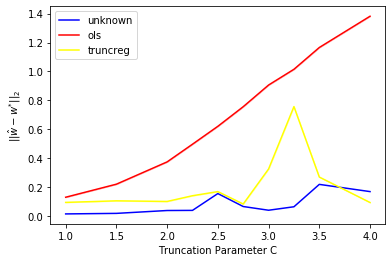

In [77]:
# plot results for regression parameter MSE
sns.lineplot(data=unknown_logs, x='c', y='unknown_param_mse', label='unknown', color='blue')
sns.lineplot(data=logs, x='c', y='ols_param_mse', label='ols', color='red')
sns.lineplot(data=truncreg_logs, x='c', y='trunc_reg_param_mse', label='truncreg', color='yellow')
plt.xlabel('Truncation Parameter C')
plt.ylabel('$||\hat w - w^{*}||_{2}$')
plt.show()

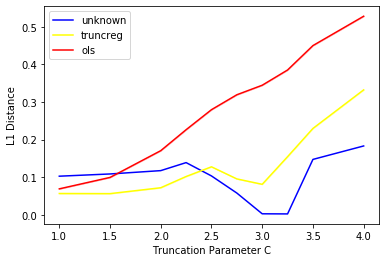

In [70]:
# plot results for regression noise variance MSE
sns.lineplot(data=unknown_logs, x='c', y='unknown_var_l1', label='unknown', color="blue")
sns.lineplot(data=truncreg_logs, x='c', y='trunc_reg_var_l1', label='truncreg', color='yellow')
ax = sns.lineplot(data=logs, x='c', y='ols_var_l1', label='ols', color="red")
ax.set(xlabel='Truncation Parameter C', ylabel='L1 Distance')
plt.show()

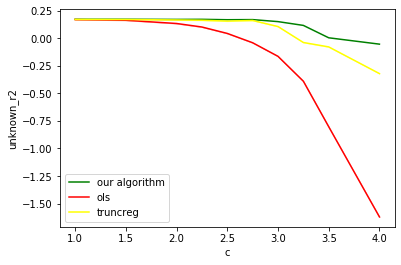

In [74]:
# plot results for regression parameter MSE
sns.lineplot(data=unknown_logs, x='c', y='unknown_r2', label='our algorithm', color='green')
sns.lineplot(data=logs, x='c', y='ols_r2', label='ols', color='red')
sns.lineplot(data=truncreg_logs, x='c', y='trunc_reg_r2', label='truncreg', color='yellow')
ax.set(xlabel='Truncation Parameter C', ylabel='L2 Distance')
plt.show()